# Radial Velocity Analysis

Since we now have extracted the spectrum from each of the science frame, we want to find the position of the spectral lines in each of the spectrum in order to compute the radial velocities.

## Position of Spectral features

We now want to find the position of the prominent spectral features in the flat corrected spectrum. The idea is to fit the Gaussian to the spectral line and thus finding the position of the line. That is a tricky procedure in the sense that, we first want to specify the location of the spectral line manually and then extract the data for only that region, and finally fitting Gaussian to that data. To make this process a little bit simpler we wrote a python script that uses the `SpanSelector` function from `matplotlib.widgets` to let user specify the location of as many lines user wants and fit Gaussian to each of them. Later, this script would save the position of each of the lines (in pixel space though) in sperate file. That file would have position of specified lines in each of the frames. Below, we can use this information to plot the position of line with time.

In the following figure, you would see the position of the four of the lines in each frames.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from astropy.io import fits
from scipy.optimize import curve_fit as cft
from scipy.optimize import minimize as mz
import os
import utils as utl

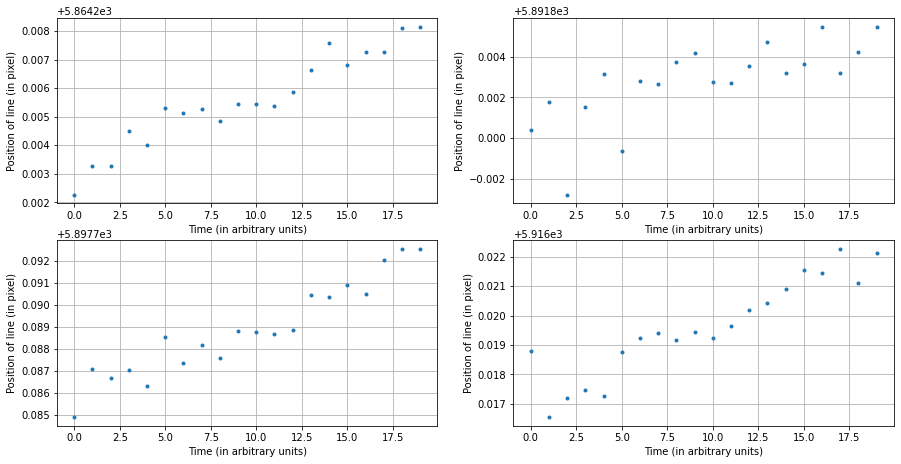

In [2]:
pos1, pos2, pos3, pos4 = np.loadtxt(os.getcwd() + '/Results/Line_pos.dat', usecols=(0,1,2,3), unpack=True)
pos1_err, pos2_err, pos3_err, pos4_err = np.loadtxt(os.getcwd() + '/Results/Line_pos_err.dat', usecols=(0,1,2,3), unpack=True)

fig0, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 7.5))
axs[0,0].errorbar(np.arange(len(pos1)), pos1, yerr=pos1_err, fmt='.')
axs[0,0].set_xlabel('Time (in arbitrary units)')
axs[0,0].set_ylabel('Position of line (in pixel)')
axs[0,0].grid()
axs[0,1].errorbar(np.arange(len(pos2)), pos2, yerr=pos2_err, fmt='.')
axs[0,1].set_xlabel('Time (in arbitrary units)')
axs[0,1].set_ylabel('Position of line (in pixel)')
axs[0,1].grid()
axs[1,0].errorbar(np.arange(len(pos3)), pos3, yerr=pos3_err, fmt='.')
axs[1,0].set_xlabel('Time (in arbitrary units)')
axs[1,0].set_ylabel('Position of line (in pixel)')
axs[1,0].grid()
axs[1,1].errorbar(np.arange(len(pos4)), pos4, yerr=pos4_err, fmt='.')
axs[1,1].set_xlabel('Time (in arbitrary units)')
axs[1,1].set_ylabel('Position of line (in pixel)')
axs[1,1].grid()

## Finding Radial Velocity of the target using Na-doublet

The rest frame wavelengths of the Sodium doublet lines are 5891.583264 A and 5897.558147 A. And we have measured the wavelengths of these two lines from the spectrum (which would be different from their rest-frame values). Using the Doppler shift formula,

$$\frac{\delta \lambda}{\lambda} = \frac{v}{c}$$

we can calculate the radial valocities. We shall first calculate the RVs from both of these lines and then find the mean values from them. After calculateing RVs, we want to correct them for barycentric velocities which were given in one of the dataset, and being use directly here.

In [3]:
bery = np.loadtxt('berv.dat', usecols=1, unpack=True)

In [4]:
rv1 = np.array([])
rv1_err = np.array([])

rv2 = np.array([])
rv2_err = np.array([])

lam1 = 5891.583264
lam2 = 5897.558147

for i in range(len(pos2)):
    # For first line
    lam_n = np.random.normal(pos2[i], pos2_err[i], 10000)
    rvn1 = ((lam_n - lam1)*299792.458/lam1) + bery[i]
    rv1 = np.hstack((rv1, np.mean(rvn1)))
    rv1_err = np.hstack((rv1_err, np.std(rvn1)))
    # For second line
    lam_m = np.random.normal(pos3[i], pos3_err[i], 10000)
    rvn2 = ((lam_m - lam2)*299792.458/lam2) + bery[i]
    rv2 = np.hstack((rv2, np.mean(rvn2)))
    rv2_err = np.hstack((rv2_err, np.std(rvn2)))

rv_avg = np.array([])
rv_avg_err = np.array([])

for i in range(len(rv1)):
    rv11 = np.random.normal(rv1[i], rv1_err[i], 10000)
    rv22 = np.random.normal(rv2[i], rv2_err[i], 10000)
    rv5 = (rv11 + rv22)/2
    rv_avg = np.hstack((rv_avg, np.mean(rv5)))
    rv_avg_err = np.hstack((rv_avg_err, np.std(rv5)))

f1 = open(os.getcwd() + '/Results/rv1.dat', 'w')
f2 = open(os.getcwd() + '/Results/rv2.dat', 'w')
f3 = open(os.getcwd() + '/Results/rv_avg.dat', 'w')

for i in range(len(rv1)):
    f1.write(str(rv1[i]) + '\t' + str(rv1_err[i]) + '\n')
    f2.write(str(rv2[i]) + '\t' + str(rv2_err[i]) + '\n')
    f3.write(str(rv_avg[i]) + '\t' + str(rv_avg_err[i]) + '\n')

f1.close()
f2.close()
f3.close()

## Relative RVs

The relative RVs is the relative radial velocity with respect to the first spectra. In this calculation, we take the position of lines in the first spectrum as the reference, and find the position of these lines in other spectra with respect to this. This is the so-called relative RVs.

In [5]:
line1 = np.random.normal(pos1[0], pos1_err[0], 10000)
line2 = np.random.normal(pos2[0], pos2_err[0], 10000)
line3 = np.random.normal(pos3[0], pos3_err[0], 10000)
line4 = np.random.normal(pos4[0], pos4_err[0], 10000)

rel_rv = np.array([])
rel_rv_err = np.array([])

for i in range(len(pos1)-1):
    ln1 = np.random.normal(pos1[i+1], pos1_err[i+1], 10000)
    ln2 = np.random.normal(pos2[i+1], pos2_err[i+1], 10000)
    ln3 = np.random.normal(pos3[i+1], pos3_err[i+1], 10000)
    ln4 = np.random.normal(pos4[i+1], pos4_err[i+1], 10000)
    # Relative RVs
    rel_v1 = ln1 - line1
    rel_v2 = ln2 - line2
    rel_v3 = ln3 - line3
    rel_v4 = ln4 - line4
    # Average Relative RVs
    rel_avg = (rel_v1 + rel_v2 + rel_v3 + rel_v4)/4
    rel_rv = np.hstack((rel_rv, np.mean(rel_avg)))
    rel_rv_err = np.hstack((rel_rv_err, np.std(rel_avg)))

f4 = open(os.getcwd() + '/Results/rel_rvs.dat', 'w')

for i in range(len(rel_rv)):
    f4.write(str(rel_rv[i]) + '\t' + str(rel_rv_err[i]) + '\n')

f4.close()